# PyTorch recurrent neural networks

This notebook demosntrates the three most common types of recurrent neural networks. 
Namely, we focus on: 
    Simple recurrent neural network   (RNN) 
    Gated recurrent units             (GRU)
    Long short term memory netowrk    (LSTM) 

The models are nicely demonstrated and explained in the following post:  
http://colah.github.io/posts/2015-08-Understanding-LSTMs/

The models are trained on a one dimensional time series of a noisy sin-wave. 


In [13]:
# load packages and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import os
%matplotlib inline
from torch import nn
from torch.autograd import Variable
import time

In [14]:
np.random.seed(0)
look_back=200        # historic time window
look_forward=100    # prediction time horizont
hidden_size=130       # dimension of hidden variable h
num_layer=3          # number of LSTM layers
dropout=   0.3      # dropout rate after each LSTM layer

epochs=1000

sample_size=3000

In [15]:
use_gpu=torch.cuda.is_available()
print("GPU is available: ",  use_gpu)


GPU is available:  True


In [16]:
# Neural netowrk 

class model(nn.Module):
    def __init__(self, module, input_size, hidden_size, output_size, num_layers, dropout):
        if module=="LSTM":
            super(model, self).__init__()    
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 

        elif module=="RNN":
            super(model, self).__init__()    
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 
        elif module=="GRU":
            super(model, self).__init__()    
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout) # rnn
            self.reg = nn.Linear(hidden_size, output_size) 
        else:
            print("No valid model")
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
    
    def predict(self, inp, input_size, future=0):
        outputs=[]
        for i in range(future):# if we should predict the future
            x, _ = self.rnn(inp) # (seq, batch, hidden)
            s, b, h = x.shape
            x = x.view(s*b, h)
            x = self.reg(x)
            x = x.view(s, b, -1)
            outputs += [x]
            inp[:,:,:(input_size-1)]=inp[:,:,1:]
            inp[:,:,-1]=x[-1].item()
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [17]:
# initialize neural nets

model_path=os.path.join("models", "2018-06-23-22-41-52")
net={}
models=['LSTM', 'RNN', 'GRU']
for name in models: 
    net[name]=torch.load(os.path.join(model_path, name))

/usr/wiss/dendorfp/.pyenv/versions/3.6.3/envs/frcnn/lib/python3.6/site-packages/torch/serialization.py:333: UserWarning: Couldn't retrieve source code for container of type model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


In [18]:
# generate data (noisy sin waves)
sample_size
def sine_2(X, signal_freq=60.):

    return (np.sin(2 * np.pi * (X) / signal_freq) + np.sin(4 * np.pi * (X) / signal_freq)) / 2.0

def noisy(Y, noise_range=(-0.05, 0.05)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

def sample(sample_size=sample_size):
    random_offset = np.random.randint(0, sample_size)
    X = np.arange(sample_size)
    Y = noisy(sine_2(X + random_offset)).astype('float32')
    return Y

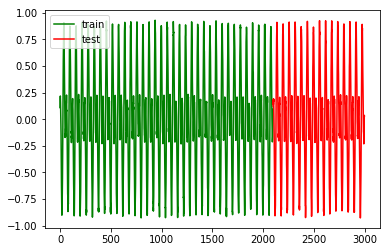

In [19]:
dataset=sample()
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

plt.plot(np.arange(train_size), dataset[:train_size], 'g', label="train") 
plt.plot(np.arange(train_size,len(dataset)), dataset[train_size:], 'r', label='test')
plt.legend()
plt.show()

In [20]:
# Normalize data to [0, 1]

max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x-min_value) / scalar, dataset))

In [21]:
def create_dataset(dataset, look_back, look_forward):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back- look_forward):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back:(i + look_back+look_forward)])
    return np.array(dataX), np.array(dataY)

In [22]:

data_X, data_Y = create_dataset(dataset, look_back, look_forward)


In [23]:
# Slit data to train and test data
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]


In [24]:
# Convert numpy array to PyTorch tensor
train_X = train_X.reshape(-1, 1, look_back)
train_Y = train_Y.reshape(-1, 1, look_forward)
test_X = test_X.reshape(-1, 1, look_back)
test_Y = test_Y.reshape(-1, 1, look_forward)

train_x = torch.from_numpy(train_X).cuda()
train_y = torch.from_numpy(train_Y).cuda()
test_x = torch.from_numpy(test_X).cuda()
test_y = torch.from_numpy(test_Y).cuda()

print(train_x.size())
print(train_y.size())
print(test_x.size())
print(test_y.size())

torch.Size([2100, 1, 200])
torch.Size([2100, 1, 100])
torch.Size([600, 1, 200])
torch.Size([600, 1, 100])


In [25]:
print(net)
for name in models:
    net[name] = net[name].eval() 
criterion = nn.MSELoss()

{'LSTM': model(
  (rnn): LSTM(200, 130, num_layers=3, dropout=0.3)
  (reg): Linear(in_features=130, out_features=100, bias=True)
), 'RNN': model(
  (rnn): RNN(200, 130, num_layers=3, dropout=0.3)
  (reg): Linear(in_features=130, out_features=100, bias=True)
), 'GRU': model(
  (rnn): GRU(200, 130, num_layers=3, dropout=0.3)
  (reg): Linear(in_features=130, out_features=100, bias=True)
)}


In [26]:
test={}
test_x=Variable(test_x)
for name in models: 
    test[name] = net[name](test_x)
    loss = criterion(test[name], test_y)
    print('{}: Loss: {:.5f}'.format(name, loss.item()))


LSTM: Loss: 0.00034
RNN: Loss: 0.00122
GRU: Loss: 0.00052


/usr/wiss/dendorfp/.pyenv/versions/3.6.3/envs/frcnn/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


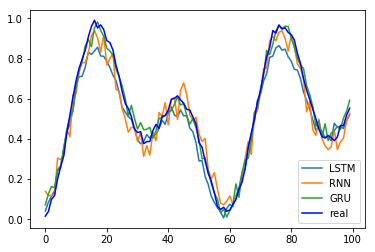

In [27]:

for name in models:
    plt.plot( test[name][0].view(-1).data.cpu().numpy(), label=name)
plt.plot(test_y[0].view(-1).data.cpu().numpy(), 'b', label='real')
plt.legend(loc='best')